# Week 5 - Non-linear regression models 

Hello again. In this notebook we will focus on non-linear regression models, specifically using **Neural Networks**!

The usual imports...

In [1]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

C:\Users\Magnus\anaconda3\envs\pyro\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

## Define error functions

In [28]:
#Function borrowed form lecture 05 to calculate standard error measures. 

def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

## Load data



In [3]:
data = pd.read_csv("archive/addtional_infor_life.csv")
LED = pd.DataFrame(data)

## Clean data

In [4]:
LED = LED.drop(['Unnamed: 0.1', 'Unnamed: 0','Adult Mortality','under-five deaths '],axis=1)
LED.dropna(inplace=True)
print(LED.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859 entries, 0 to 2937
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1859 non-null   object 
 1   continent                        1859 non-null   object 
 2   Life expectancy                  1859 non-null   float64
 3   Year                             1859 non-null   float64
 4   Status                           1859 non-null   float64
 5   infant deaths                    1859 non-null   float64
 6   Alcohol                          1859 non-null   float64
 7   percentage expenditure           1859 non-null   float64
 8   Hepatitis B                      1859 non-null   float64
 9   Measles                          1859 non-null   float64
 10   BMI                             1859 non-null   float64
 11  Polio                            1859 non-null   float64
 12  Total expenditure   

## Load data to NP arrays

In [5]:
mat = LED.values
X_numpy = np.array(mat[:,4:],float) #These are the regressors
print(X_numpy.shape)

y_numpy = np.array(mat[:,2],float) #This is the target variable life expectancy
print(y_numpy.shape)

ind = mat[:,1] #These are the hierarchies
print(ind.shape)

(1859, 17)
(1859,)
(1859,)


## Standardize data

In [6]:
# standardize input features
X_mean = X_numpy.mean(axis=0)
X_std = X_numpy.std(axis=0)
X = (X_numpy - X_mean) / X_std

# standardize target
y_mean = y_numpy.mean()
y_std = y_numpy.std()
y = (y_numpy - y_mean) / y_std

## Splitting into test and training

In [7]:
#Setup split for traning and test data set. We will use 2000-2012 as traning and 2013-2015 as test. 
training_idx = (LED['Year'] >= 2000) & (LED['Year'] <= 2012)
test_idx = (LED['Year'] >= 2013) & (LED['Year'] <= 2015)

X_train = X[training_idx,:]
X_test = X[test_idx,:]

y_train = y[training_idx]
y_test = y[test_idx]

ind_train = ind[training_idx]
ind_test  = ind[test_idx]

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 1566
num test: 293


## Running plain linear regression

In [8]:
from sklearn import datasets, linear_model

regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(X_numpy, y_numpy)
preds_lr = regr.predict(X_test)
print(regr.coef_)

[-2.01918618e+00  5.26400219e-03 -3.23291359e-01  4.53640904e-04
  3.00929174e-02  6.27283034e-05  9.42694737e-02  8.36180336e-02
  9.87723288e-01  1.00736018e-01 -4.43120785e-01 -6.64873748e-05
 -1.25458455e-08  5.02797122e-01  2.80304051e-01  1.51839053e+01
  2.48188011e+00]


In [9]:
mae = np.mean(np.abs(y_test-preds_lr))
print("MAE:", mae)

MAE: 11.43436095284416


## Define Neural Network model in Pyro

In [10]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
class FFNN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        prediction_mean = X.squeeze(-1)
        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
            
        return y

## Setup NNet model

In [11]:
# Prepare data for Pyro by converting it into PyTorch tensors
X = torch.tensor(X).float()
y = torch.tensor(y).float()

In [12]:
# Define guide function
model = FFNN(n_in=X.shape[1], n_hidden=4, n_out=1)
guide = AutoDiagonalNormal(model)
pyro.clear_param_store()

## Run SVI on the NNet

In [13]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X, y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 86138.3
[500] ELBO: 10790.8
[1000] ELBO: 8930.1
[1500] ELBO: 8035.1
[2000] ELBO: 7031.9
[2500] ELBO: 6946.5
[3000] ELBO: 6818.6
[3500] ELBO: 6695.1
[4000] ELBO: 6376.4
[4500] ELBO: 6316.9
[5000] ELBO: 6161.7
[5500] ELBO: 6252.3
[6000] ELBO: 6080.0
[6500] ELBO: 5973.1
[7000] ELBO: 5906.8
[7500] ELBO: 5806.1
[8000] ELBO: 5766.4
[8500] ELBO: 5689.2
[9000] ELBO: 5691.0
[9500] ELBO: 5711.3


After convergence, we can make predictions for the test set by again leveraging the ```Predictive``` class provided by Pyro:

In [14]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test).float()

In [15]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

Let's now calculate the MAE and compare it with the linear regression model from above:

In [31]:
y_true = y_test * y_std + y_mean

y_pred = samples["obs"].mean(axis=0).detach().numpy() * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, y_pred)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.954
MAE: 1.812
RMSE: 2.508
R2: 0.907


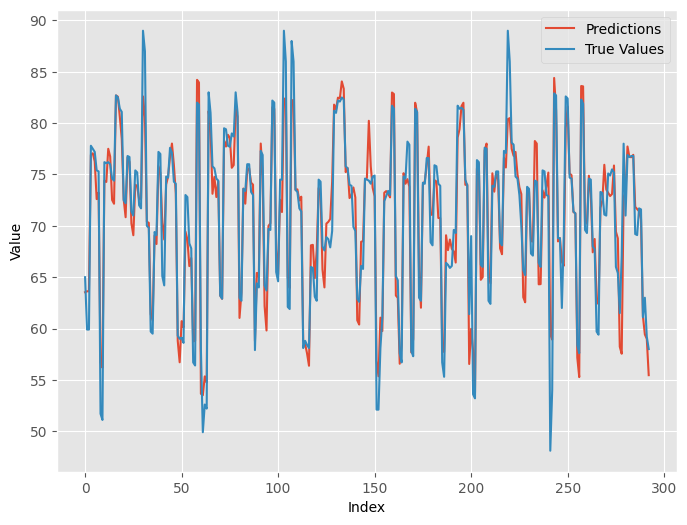

In [20]:
plt.plot(y_pred, label='Predictions')
plt.plot(y_true, label='True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

## Defining NNet + linear Bay regression
Right now defined with first variable as linear rest in NNet

In [35]:
class FFNN_interpretable(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN_interpretable, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        X_nn = X[:,1:]
        X_nn = self.tanh(self.in_layer(X_nn))
        X_nn = self.tanh(self.h_layer(X_nn))
        X_nn = self.out_layer(X_nn)
        nn_out = X_nn.squeeze(-1)

        beta_lin = pyro.sample("beta", dist.Normal(0, 1))
        X_linear = X[:,0]
        with pyro.plate("observations"):
            linear_out = X_linear*beta_lin
            y = pyro.sample("obs", dist.Normal(nn_out+linear_out, 0.1), obs=y)
            
        return y

## Run SVI on the NNet + LR

In [36]:
# Define guide function
model = FFNN_interpretable(n_in=X.shape[1]-1, n_hidden=4, n_out=1) 
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X, y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 96338.7
[500] ELBO: 10001.3
[1000] ELBO: 8015.5
[1500] ELBO: 7624.3
[2000] ELBO: 6934.4
[2500] ELBO: 6443.3
[3000] ELBO: 6186.2
[3500] ELBO: 5972.7
[4000] ELBO: 5777.2
[4500] ELBO: 5794.0
[5000] ELBO: 5736.2
[5500] ELBO: 5705.8
[6000] ELBO: 5669.8
[6500] ELBO: 5629.1
[7000] ELBO: 5421.3
[7500] ELBO: 5494.4
[8000] ELBO: 5435.0
[8500] ELBO: 5308.7
[9000] ELBO: 5371.8
[9500] ELBO: 5382.5


Let us now have a look at the estimated value for the coefficient $\beta$ over the input dimension $x_1$:

In [23]:
from pyro.infer import Predictive

# Get posterior samples for beta
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta",))
samples = predictive(X, y)

In [24]:
print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

Estimated beta: 0.01259487


In [25]:
# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

In [32]:
y_true = y_test * y_std + y_mean

y_pred = samples["obs"].mean(axis=0).detach().numpy() * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, y_pred)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.954
MAE: 1.812
RMSE: 2.508
R2: 0.907


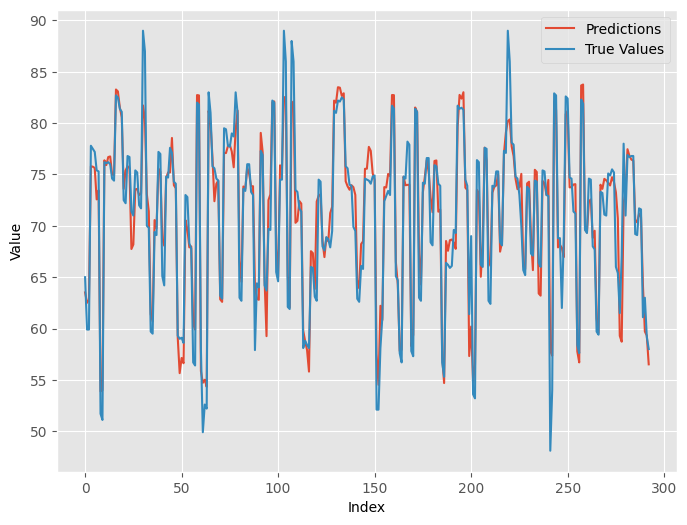

In [27]:
plt.plot(y_pred, label='Predictions')
plt.plot(y_true, label='True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()